In [64]:
# data analysis libraries
import pandas as pd
import numpy as np

# Kaggle requirements
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# visualisation libraries
from matplotlib import pyplot as plt
import seaborn as sns
from numpy.random import RandomState
import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, preprocessing)


#word cloud
%matplotlib inline
import wordcloud

from wordcloud import WordCloud, STOPWORDS
%matplotlib inline
sns.set()

# visualisation libraries
from matplotlib import pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

# Import KMeans model
from sklearn.cluster import KMeans


# ML Models
from sklearn.decomposition import PCA
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ML Pre processing
from sklearn.model_selection import train_test_split
#from surprise.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Hyperparameter tuning
from surprise.model_selection import GridSearchCV

# High performance hyperparameter tuning
#from tune_sklearn import TuneSearchCV
#import warnings
#warnings.filterwarnings("ignore")

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

In [65]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df_movies = pd.read_csv('movies.csv')
df_samp = pd.read_csv('sample_submission.csv')
df_imdb = pd.read_csv('imdb_data.csv')
df_gtags = pd.read_csv("genome_tags.csv")
df_scores = pd.read_csv("genome_scores.csv")
df_tags = pd.read_csv("tags.csv")
df_links = pd.read_csv("links.csv")

In [66]:
#viewing training data
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [67]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [68]:
#Viewing movies data
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [69]:
#Viewing imdb dataframe

df_imdb.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [70]:
#Viewing Genrome tags
df_gtags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [71]:
#Viewing scores
df_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [72]:
#viewing tags
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [73]:
#view links
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [74]:
#check for missing values
train.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [75]:
test.isnull().sum()

userId     0
movieId    0
dtype: int64

In [76]:
# check duplicates
dup_bool = train.duplicated(['userId', 'movieId', 'rating'])

# display duplicates
print("Number of duplicate records:", sum(dup_bool))

Number of duplicate records: 0


In [77]:
# check duplicates
dup_bool = test.duplicated(['userId', 'movieId'])

# display duplicates
print("Number of duplicate records:", sum(dup_bool))

Number of duplicate records: 0


In [78]:
# Create a copy
train_f = train.copy()

In [79]:
df_test = test.copy()

In [80]:
## Scalling 
### Unscaled
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')


In [81]:
# using plotly to plot the boxplot
train_f[:1000].iplot(kind='box', title="Boxplots of Features (Unscaled)")
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')


In [82]:
# using plotly to plot the boxplot
df_test[:1000].iplot(kind='box', title="Boxplots of Features (Unscaled)")
### Scaled

In [83]:
# create scaler object
scaler = StandardScaler()

# define scaled data frame variable

train_scaled = preprocessing.scale(train_f)
train_scaled = pd.DataFrame(train_scaled)
# plot boxplots using scaled data
train_scaled[:1000].iplot(kind='box', title="Boxplots of Features (Scaled)")

In [84]:
# create scaler object
scaler = StandardScaler()

# define scaled data frame variable

test_scaled = preprocessing.scale(df_test)
test_scaled = pd.DataFrame(test_scaled)
# plot boxplots using scaled data
test_scaled[:1000].iplot(kind='box', title="Boxplots of Features (Scaled)")

In [85]:
# Merge the ratings and movies
df_merge1 = train_f.merge(df_movies, on='movieId')
# View the first 5 rows
df_merge1.head()

,userId,movieId,rating,timestamp,title,genres
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller


In [86]:
# Merge the ratings and movies
df_merge1_test = df_test.merge(df_movies, on='movieId')
# View the first 5 rows
df_merge1_test.head()

,userId,movieId,title,genres
0,1,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
1,13,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
2,54,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
3,57,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi
4,120,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi


In [87]:
df_merge2 = df_merge1.merge(df_imdb, on="movieId")
# View first 5 rows
df_merge2.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [88]:
df_merge2_test = df_merge1_test.merge(df_imdb, on="movieId")
# View first 5 rows
df_merge2_test.head()

,userId,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN
1,13,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN
2,54,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN
3,57,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN
4,120,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN


In [89]:
# Merging the merge data earlier on with the df_imbd
df_merge3 = df_merge2.merge(df_imdb, on="movieId" )
# View first 5 rows
df_merge3.head()

,userId,movieId,rating,timestamp,title,genres,title_cast_x,director_x,runtime_x,budget_x,plot_keywords_x,title_cast_y,director_y,runtime_y,budget_y,plot_keywords_y
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,87388,57669,3.5,1237455297,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
2,137050,57669,4.0,1425631854,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
3,120490,57669,4.5,1408228517,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4,50616,57669,4.5,1446941640,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman


In [90]:
# Merging the merge data earlier on with the df_imbd
df_merge3_test = df_merge2_test.merge(df_imdb, on="movieId" )
# View first 5 rows
df_merge3_test.head()

,userId,movieId,title,genres,title_cast_x,director_x,runtime_x,budget_x,plot_keywords_x,title_cast_y,director_y,runtime_y,budget_y,plot_keywords_y
0,1,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,54,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,120,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
major= df_merge3.drop_duplicates('movieId')
major.head(2)

,userId,movieId,rating,timestamp,title,genres,title_cast_x,director_x,runtime_x,budget_x,plot_keywords_x,title_cast_y,director_y,runtime_y,budget_y,plot_keywords_y
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
4253,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [92]:
major_test = df_merge3_test.drop_duplicates('movieId')
major_test.head(2)

,userId,movieId,title,genres,title_cast_x,director_x,runtime_x,budget_x,plot_keywords_x,title_cast_y,director_y,runtime_y,budget_y,plot_keywords_y
0,1,2011,Back to the Future Part II (1989),Adventure|Comedy|Sci-Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4658,1,4144,In the Mood For Love (Fa yeung nin wa) (2000),Drama|Romance,Maggie Cheung|Tony Chiu-Wai Leung|Ping Lam Siu...,Kar-Wai Wong,98.0,NaN,adultery|loneliness|neighbor|infidelity,Maggie Cheung|Tony Chiu-Wai Leung|Ping Lam Siu...,Kar-Wai Wong,98.0,NaN,adultery|loneliness|neighbor|infidelity


In [93]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(train_f)

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)


Text(0, 0.5, 'Cumulative explained variance')

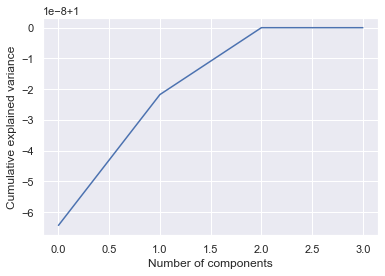

In [94]:
# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [95]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(test_scaled)

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)

88.0 % of variance explained by 3 components.


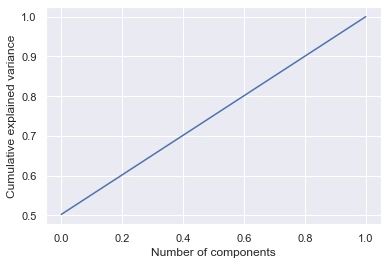

In [96]:
# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
pca_85 = PCA(.85)
pca_85.fit_transform(train_scaled)
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")

In [97]:
pca.explained_variance_ratio_[:3]
pca_85 = PCA(.85)
pca_85.fit_transform(test_scaled)
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")

100.0 % of variance explained by 2 components.


In [98]:
labels = ['timestamp']
features = [col for col in train.columns if col not in labels]

In [99]:

## 2. Data Engineering
X = train[features].drop(columns=['rating'])
y = train['rating']

In [100]:
# define scaled data frame variable
# create scaler object
scaler = StandardScaler()
X_scaled = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)


In [101]:
### Clustering
# create PCA object with n_components set to 13
pca_reg = PCA(n_components=2)
# fit the PCA model to our data and apply the dimensionality reduction 
X_train = pca_reg.fit_transform(X_train)

In [102]:
# confirm the number of components
pca_reg.n_components_
pca_reg.explained_variance_ratio_.sum()


1.0

In [103]:
## 3. Modeling
#### Linear Model 
# instantiate model with 1000 decision trees
lr = LinearRegression()
# train the model on training data
lr.fit(X_train, y_train)
# use the forest's predict method on the test data
predictions = lr.predict(X_test)

# calculate the absolute errors
errors = abs(predictions - y_test)

In [104]:
# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))



Mean Absolute Error: 0.84


In [105]:
#### Decision Tree Regression
# instantiate model with 1000 decision trees
dt = DecisionTreeRegressor(max_depth = 100)

In [106]:
# train the model on training data
dt.fit(X_train, y_train)
# use the forest's predict method on the test data
pred_dt = dt.predict(X_test)

In [107]:
# calculate the absolute errors
errors = abs(pred_dt - y_test)
# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))


Mean Absolute Error: 1.35


In [108]:
#### Random Forest 
'''# instantiate model with 1000 decision trees
rf = RandomForestRegressor(max_depth = 10)'''
# train the model on training data
'''rf.fit(X_train, y_train)
use the forest's predict method on the test data
pred_rf = rf.predict(X_test)
# calculate the absolute errors
errors = abs(pred_rf - y_test)
# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
'''

"rf.fit(X_train, y_train)\nuse the forest's predict method on the test data\npred_rf = rf.predict(X_test)\n# calculate the absolute errors\nerrors = abs(pred_rf - y_test)\n# print out the mean absolute error (mae)\nprint('Mean Absolute Error:', round(np.mean(errors), 2))\n"

In [109]:
#### Test Predictions
X_test = pca_reg.transform(test_scaled)
predictions = lr.predict(X_test)
pred_dt = dt.predict(X_test)

In [110]:
# Run your code and go to /
### Multi-Dimensional Scaling
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, 
                   n_init=4, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
X_mds = clf.fit_transform(X_train[:5000])
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, 
                   n_init=4, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
X_mds = clf.fit_transform(test_scaled[:5000])

Computing MDS embedding
Computing MDS embedding


In [111]:
#### T-SNE 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2,
                     perplexity=40,
                     metric='euclidean',
                     init='pca',
                     verbose=1,
                     random_state=42)
X_tsne = tsne.fit_transform(X_train[:5000])

Computing t-SNE embedding
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.127s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.031159
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.591164
[t-SNE] KL divergence after 1000 iterations: 0.499761


In [112]:
#### Linear Regression
# instantiate model with 1000 decision trees
lr = LinearRegression()

In [113]:
# train the model on training data
lr.fit(X_train, y_train)
# use the forest's predict method on the test data
predictions = lr.predict(X_test)

# calculate the absolute errors
errors = abs(predictions - y_test)

In [114]:
# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))
### Decision Trees
# instantiate model with 1000 decision trees
dt = DecisionTreeRegressor(max_depth = 100)

# train the model on training data
dt.fit(X_train, y_train)
# use the forest's predict method on the test data
pred_dt = dt.predict(X_test)

Mean Absolute Error: 0.84


In [115]:
# calculate the absolute errors
errors = abs(pred_dt - y_test)
# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.03


In [116]:
#### Test Predictions
X_test = pca_reg.transform(test_scaled)
predictions = lr.predict(X_test)
pred_dt = dt.predict(X_test)


In [117]:
km = KMeans(n_clusters = 3, random_state=42)
km.fit(X_train, y_train)

KMeans(n_clusters=3, random_state=42)

In [118]:
X_test = pca_reg.transform(test_scaled)

In [119]:
# obtain cluster memberships for each item in the data
y_preds_Kmeans = km.predict(X_test)

### Hierarch

### Gausian 

## Kaggle 

In [120]:
Id = test.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

In [121]:
Kmeans_output = pd.DataFrame(y_preds_Kmeans, columns = ['rating'])
id = pd.DataFrame(Id, columns = ['id'])
Kmeans_output = id.join(Kmeans_output)

In [122]:
Kmeans_output.to_csv('submission_kmeans.csv', index = False)

Kmeans_output

,id,rating
0,1_2011,1
1,1_4144,1
2,1_5767,1
3,1_6711,1
4,1_7318,1
...,...,...
5000014,162541_4079,2
5000015,162541_4467,2
5000016,162541_4980,2
5000017,162541_5689,2
